# Self-organizing map work-flow with 6-hourly data

Notebook by: Maria J. Molina (NCAR) and Annareli Morales (NOAA)

Imports

In [1]:
import warnings
from itertools import product
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cf
from minisom import MiniSom, asymptotic_decay

### helper functions

In [2]:
def normalize_data(data):
    """
    Function for normalizing data prior to training using z-score
    """
    return (data - np.nanmean(data)) / np.nanstd(data)

In [3]:
def hour_select(data, hour, time='time'):
    """
    Select hour.

    Args:
        data (xarray dataarray): Data Array weighted mean already computed.
        hour (int): Hour for climatology.
        time (str): Time coordinate name. Defaults to ``time``.
    """
    return data[data[f'{time}.hour'] == hour]

In [4]:
def roll_climo(data, month, yrsroll=30, centered=True, time='time'):
    """
    Creating rolling 30-year mean climatology.

    Args:
        data (xarray dataarray): Data Array weighted mean already computed.
        month (int): Month for climatology.
        yrsroll (int): Number of years for climatology. Defaults to ``30``.
        centered (boolean): Whether the average is centered. Defaults to ``True``.
        time (str): Time coordinate name. Defaults to ``time``.
    """
    return data[data[f'{time}.month'] == month].rolling(
        time=yrsroll, min_periods=1, center=centered).mean()

In [5]:
def monthly_climo_perhour(data, yrsroll=30, centered=True, time='time'):
    """
    Create rolling mean climatology. 
    Performs what xr.DataArray.groupby('time.month').rolling() would do.

    Args:
        data (xarray data array): Weighted mean variable.
        yrsroll (int): Number of years for climatology. Defaults to ``30``.
        centered (boolean): Whether the average is centered. Defaults to ``True``.
        time (str): Time coordinate name. Defaults to ``time``.

    Returns:
        nino_climo with rolling mean computed along months.
    """
    month_list = ['jan', 'feb', 'mar', 'apr', 'may', 'jun',
                  'jul', 'aug', 'sep', 'boo', 'nov', 'dec']

    months_dict_h00 = {}
    months_dict_h06 = {}
    months_dict_h12 = {}
    months_dict_h18 = {}

    with warnings.catch_warnings():

        # ignore computer performance warning here on chunks
        warnings.simplefilter("ignore")

        for it_mo, mo in enumerate(month_list):

            months_dict_h00[mo] = roll_climo(
                hour_select(data, 0), month=it_mo+1, yrsroll=yrsroll,
                centered=centered, time=time)

        for it_mo, mo in enumerate(month_list):

            months_dict_h06[mo] = roll_climo(
                hour_select(data, 6), month=it_mo+1, yrsroll=yrsroll,
                centered=centered, time=time)

        for it_mo, mo in enumerate(month_list):

            months_dict_h12[mo] = roll_climo(
                hour_select(data, 12), month=it_mo+1, yrsroll=yrsroll,
                centered=centered, time=time)

        for it_mo, mo in enumerate(month_list):

            months_dict_h18[mo] = roll_climo(
                hour_select(data, 18), month=it_mo+1, yrsroll=yrsroll,
                centered=centered, time=time)

        nino_climo = xr.concat([
            months_dict_h00['jan'], months_dict_h06['jan'], months_dict_h12['jan'], months_dict_h18['jan'],
            months_dict_h00['feb'], months_dict_h06['feb'], months_dict_h12['feb'], months_dict_h18['feb'],
            months_dict_h00['mar'], months_dict_h06['mar'], months_dict_h12['mar'], months_dict_h18['mar'],
            months_dict_h00['apr'], months_dict_h06['apr'], months_dict_h12['apr'], months_dict_h18['apr'],
            months_dict_h00['may'], months_dict_h06['may'], months_dict_h12['may'], months_dict_h18['may'],
            months_dict_h00['jun'], months_dict_h06['jun'], months_dict_h12['jun'], months_dict_h18['jun'],
            months_dict_h00['jul'], months_dict_h06['jul'], months_dict_h12['jul'], months_dict_h18['jul'],
            months_dict_h00['aug'], months_dict_h06['aug'], months_dict_h12['aug'], months_dict_h18['aug'],
            months_dict_h00['sep'], months_dict_h06['sep'], months_dict_h12['sep'], months_dict_h18['sep'],
            months_dict_h00['boo'], months_dict_h06['boo'], months_dict_h12['boo'], months_dict_h18['boo'],
            months_dict_h00['nov'], months_dict_h06['nov'], months_dict_h12['nov'], months_dict_h18['nov'],
            months_dict_h00['dec'], months_dict_h06['dec'], months_dict_h12['dec'], months_dict_h18['dec']],
            dim=time).sortby(time)

    return nino_climo

In [6]:
def monthly_mean_anom(da):
    """
    Computing monthly anomalies (using the full climatological period).
    """
    anom = da.groupby('time.month') - da.groupby(
        'time.month').mean(skipna=True)
    return anom

In [7]:
def rolling_monthly_mean_hourly_anom(da):
    """
    Computing monthly anomalies (using 30-year rolling mean applied per hour).
    """
    climo = monthly_climo_perhour(da)
    anom = da - climo
    return anom

In [8]:
def level_selector(ds):
    """
    Function to help extract single level (500 hPa) when opening all files.
    """
    return ds.sel(level=500.)

## Opening of all files with ``xarray``

Here we use the function ``open_mfdataset`` to open multiple files and concatenate along a dimention (as specified).

First, I am testing with ERA5 data since it is available on the NCAR clusters.

Use wildcard in place of specific dates in folder/directory names and filenames.

In [9]:
# ERA5 data (for code development)
ds = xr.open_mfdataset(
    '/gpfs/fs1/collections/rda/data/ds633.0/e5.oper.an.pl/*/e5.oper.an.pl.128_129_z.ll025sc.*.nc',
    concat_dim='time', preprocess=level_selector)

### Computing rolling monthly mean, but applied to 6-hour periods separately.

In [10]:
ro_mean_anom = rolling_monthly_mean_hourly_anom(ds['Z'])

Continue workflow with this data array ``ro_mean_anom``

In [18]:
data_train = ro_mean_anom.sel(lat=slice(20, 55), lon=slice(254-30, 254+12))

In [14]:
data_train = data_train.stack(latlon=['lat', 'lon']).values

In [15]:
data_train = normalize_data(data_train)

In [16]:
# plt.plot(data_train[:, 200])
# plt.show()

### Note that the dimensions of data_train should be in (samples, features/grid cells) before going into minisom for training!

## Minisom

In [18]:
# SOM hyperparameters

som_grid_rows = 3           # (y-axis)
som_grid_columns = 3        # (x-axis)

input_length = data_train.shape[1]

sigma = 2.0               # Spread of the neighborhood function, needs to be adequate to the dimensions of the map. (rows/columns minus 1 usually)
learning_rate = 0.5       # initial learning rate (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
decay_function = asymptotic_decay

"""Function that reduces learning_rate and sigma at each iteration
    the default function is (asymptotic_decay):
                learning_rate / (1+t/(max_iterarations/2))

    A custom decay function will need to to take in input
    three parameters in the following order:

    1. learning rate
    2. current iteration
    3. maximum number of iterations allowed

    Note that if a lambda function is used to define the decay
    MiniSom will not be pickable anymore."""

neighborhood_function = 'gaussian'

"""Function that weights the neighborhood of a position in the map. 
    Possible values: 'gaussian', 'mexican_hat', 'bubble', 'triangle', 
    which takes in sigma."""

topology = 'rectangular'                 # Topology of the map; Possible values: 'rectangular', 'hexagonal'
activation_distance = 'euclidean'        # Distance used to activate the map; Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
random_seed = 1                          # Random seed to use for reproducibility. Using 1.

In [19]:
som = MiniSom(
            som_grid_rows,
            som_grid_columns,
            input_length,
            sigma,
            learning_rate,
            decay_function,
            neighborhood_function,
            topology,
            activation_distance,
            random_seed)

In [21]:
# som.pca_weights_init(data_train)   # note for annareli -- to test later
som.random_weights_init(data_train)

In [22]:
som.get_weights()
# just vieweing the random weights

array([[[-1.44704762e-01, -1.57376085e-01, -1.84628949e-01, ...,
         -1.66473104e-01, -1.66334884e-01, -1.73608983e-01],
        [ 2.58982737e-03,  2.32396837e-02,  3.02100635e-02, ...,
         -1.22919838e+00, -1.34787185e+00, -1.46483153e+00],
        [-3.73953145e-01, -3.39069116e-01, -3.01842026e-01, ...,
          1.47997268e+00,  1.54166703e+00,  1.60050302e+00]],

       [[ 1.80090810e-01,  1.79772542e-01,  1.79578549e-01, ...,
          1.16481488e+00,  1.25902231e+00,  1.35200031e+00],
        [ 2.21232904e-01,  2.46597981e-01,  2.75553732e-01, ...,
         -5.62647474e-01, -5.49293541e-01, -5.33207349e-01],
        [-6.15905695e-01, -6.24415518e-01, -6.30430197e-01, ...,
         -1.12712689e+00, -1.12774366e+00, -1.12095841e+00]],

       [[ 2.69212008e-01,  2.99165606e-01,  3.25363637e-01, ...,
          1.61771498e+00,  1.61235897e+00,  1.60204708e+00],
        [ 1.41660969e-01,  1.18079406e-01,  9.72761748e-02, ...,
          7.74602737e-01,  7.87032176e-01,  8.023

In [20]:
epochs = 10000
random_order = True
verbose = True

In [23]:
som.train(
        data_train,
        epochs,
        random_order,
        verbose)

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 60.35024122979245


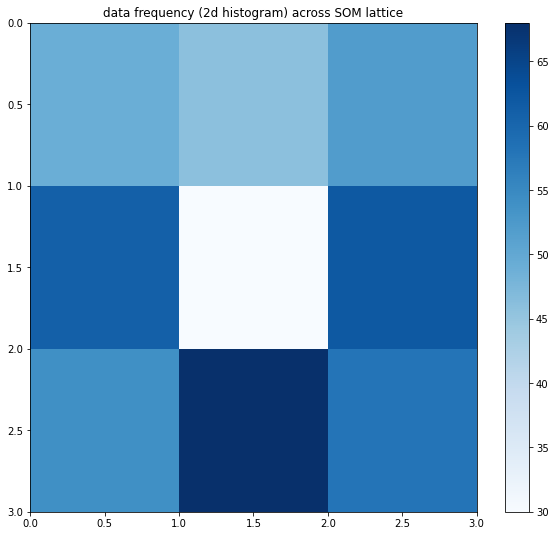

In [24]:
plt.figure(figsize=(10, 9))
frequencies = som.activation_response(data_train)
plt.pcolormesh(frequencies, cmap='Blues')
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(som_grid_rows, 0)  # flip the y axis to be the same as composite map axes later
plt.show()

In [25]:
# grabbing indices from SOM

# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(som_grid_rows), range(som_grid_columns))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data_train):
    winmap[som.winner(x)].append(i)

In [26]:
som_keys = list(winmap.keys())
print(f"Number of SOM nodes: {len(som_keys)}")

Number of SOM nodes: 9


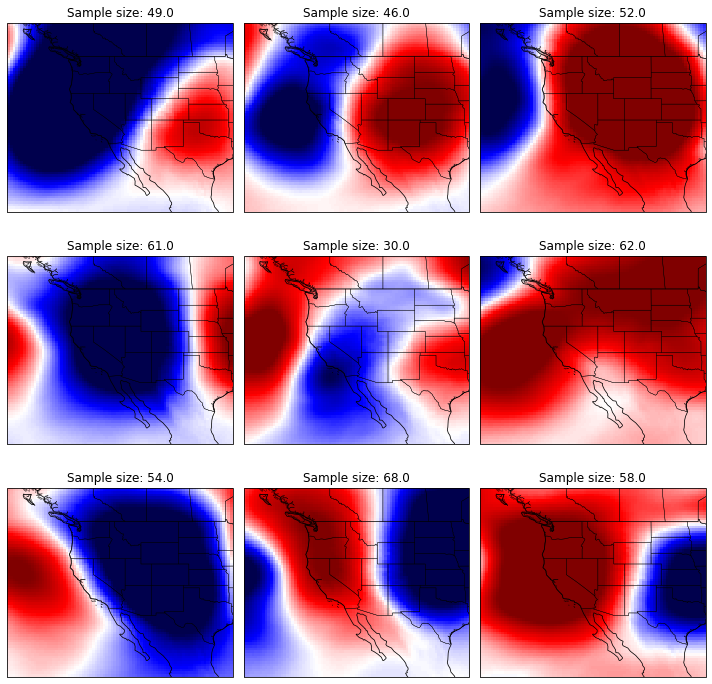

In [27]:
# view all SOM composite maps
# (this cell takes a few minutes to run, especially if SOM lattice is large)

lats = ro_mean_anom.sel(lat=slice(20, 55), lon=slice(254-30, 254+12)).lat
lons = ro_mean_anom.sel(lat=slice(20, 55), lon=slice(254-30, 254+12)).lon

# create a figure using the same dimensions as SOM
fig, axs = plt.subplots(som_grid_rows, som_grid_columns,
                        subplot_kw=dict(projection=ccrs.PlateCarree()),
                        figsize=(10, 10))

# (1) loop through the SOM neurons, (2) grab data samples using SOM indices, (3) compute the mean for each SOM neuron, plot each

for map_num in range(len(som_keys)):

    # the data
    temp_data = ro_mean_anom.sel(lat=slice(20, 55), lon=slice(254-30, 254+12))[
        np.array(winmap[som_keys[map_num]])].mean(dim="time", skipna=True).values

    # plot
    axs[som_keys[map_num][0], som_keys[map_num][1]].pcolormesh(
        lons, lats, temp_data, cmap="seismic", vmin=-40, vmax=40, transform=ccrs.PlateCarree())
    # title
    axs[som_keys[map_num][0], som_keys[map_num][1]].set_title(f"Sample size: {frequencies.flatten()[map_num]}", fontsize=12)

    # add stuff
    axs[som_keys[map_num][0], som_keys[map_num][1]].coastlines(
        resolution='110m', color='k', linewidth=0.75, zorder=10)
    axs[som_keys[map_num][0], som_keys[map_num][1]].margins(x=0, y=0)
    axs[som_keys[map_num][0], som_keys[map_num][1]].add_feature(
        cfeature.STATES, facecolor='none', edgecolor='k', linewidth=0.35, zorder=10)
    axs[som_keys[map_num][0], som_keys[map_num][1]].add_feature(
        cf.BORDERS, linewidth=0.35, zorder=10)
    # axs[som_keys[map_num][0], som_keys[map_num][1]].set_extent([-141, -69, 20, 70], crs=ccrs.PlateCarree())

# plot the figure containing all plots
plt.tight_layout()
plt.show()